# Tarea 2: Programación No Lineal
## Autor: Leonard David Vivas Dallos

### Instrucción: 
Esta actividad se realizará en forma individual. Las actividades a realizar son las siguientes: 

1. Elija un ejemplo donde se requiera encontrar los parámetros a un modelo matemático y se disponga de datos experimentales. Se solicita que el modelo sea de algo aplicado a un problema real. 
2. Implemente el método de región de confianza y de Gauss-Newton.
3. Utilice ambos algoritmos para resolver el problema seleccionado. ¿Qué diferencias detectó?
4. Realice un informe escrito donde describa el ejemplo seleccionado con las referencias correspondientes. Adicionalmente, muestre la solución del problema usando los dos métodos y haga una discusión de los resultados obtenidos.  

Se deben subir al Moodle los siguientes archivos: 
- Informe escrito 
- Códigos usados en las implementaciones

### 1. Selección del problema
Para esta tarea se seleccionó el problema de ajuste de curvas a un conjunto de datos experimentales. En particular, intentaremos ajustar un modelo exponencial a un conjunto de datos poblacionales alojados en el archivo 'PoblaciónEspaña.csv' y tomados de la página del Instituto Nacional de Estadística, con enlace "https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177095&menu=ultiDatos&idp=1254735572981". Estos datos hacen parte de los resultados de los censos y registros de población periódicos realizados alrededor de la población española, datos que han sido reportados en su mayoría como datos finales y definitivos (a excepción de los últimos 4, que aún no han sido confirmados, pero no es algo que nos interese en términos de este trabajo).

Así pues, el modelo exponencial con el cual vamos a estar trabajando se define como:

$$C(t) = C_0 e^{kt}$$

Donde $C(t)$ es la población en el tiempo $t$, $C_0$ es la población inicial estimada y $k$ es la tasa de crecimiento. Nuestro objetivo será entonces encontrar los valores de $C_0$ y $k$ que mejor se ajusten a los datos experimentales proporcionados por el archivo.

Con el fin de desarrollar y cumplir con nuestro objetivo, se planteará el problema descrito como un problema de optimización no lineal, específicamente un problema de identificación de parámetros con la técnica de los problemas de mínimos cuadrados, en donde la función objetivo a minimizar es:

$$\min_{C_0, k} \sum_{i=1}^{n} (C_i - C_0 e^{kt_i})^2$$

Donde $C_i$ es la población en el tiempo $t_i$ y $n$ es el número de datos experimentales.

El conjunto de datos entonces corresponde a los datos de la población residente en España entre los años 1971 - 2024, delimitando periodos de tiempo trimestrales entre los datos (sin embargo, no se cuenta con la totalidad de los 4 trimestres en algunos años, por causas que son desconocidas y de poca relevancia) y generados por la entidad encargada en dicho país, lo que sugiere datos confiables y útiles. A continuación se muestra la carga de los datos y la visualización de los mismos.

In [96]:
# Definición de los datos experimentales a usar
import pandas as pd # Librería usada para el manejo de los datos alojados en el archivo .csv

# Lectura de los datos omitiendo las primeras 7 filas (filas de información cualitativa de los datos)
data = pd.read_csv('PoblaciónEspaña.csv', skiprows=7)

# Filtrado por las columnas de interés, 'PERIODO' y 'VALOR'
data = data[['PERIODO', 'VALOR']]

# Visualización de los datos
data.head()

,PERIODO,VALOR
0,2024T1,48.592.909
1,2023T4,48.507.039
2,2023T3,48.373.336
3,2023T2,48.233.001
4,2023T1,48.085.361


NOTA: Si se desea ver una muestra más amplia de los datos, podemos ingresar un parámetro a la función 'head', con el número de casos a visualizar, como por ejemplo `data.head(10)`

Examinando un poco los datos obtenidos, notamos que el periodo de tiempo se encuentra en una escala trimestral, es decir, en un formato $año + T + trimestre$, lo cual no es precisamente recomendable para manejar este tipo de escala como tiempo en sí. Así, procederemos a convertir estos valores a una escala apropiada, una escala de años, en donde por convención, al ser un total de 4 trimestres por año, usaremos el valor del trimestre que se tiene y se sumará al año en sí el valor correspondiente (0.25, 0.5, 0.75 o 1 año). Para lograr este fin, se procederá añadiendo una columna adicional al índice de nuestro DataFrame (conjunto de datos) que contenga nuestro valor a usar en la escala anual, para posteriormente usarlo en reemplazo de la columna 'PERIODO'.

In [97]:
# Crear una nueva columna con el valor del año en escala anual

# Dividir la columna 'PERIODO' en sus dos partes
data[['AÑO', 'TRIMESTRE']] = data['PERIODO'].str.split('T', expand=True)

# Conversión de 'AÑO' y 'PERIODO' a enteros
data['AÑO'] = data['AÑO'].astype(int)
data['TRIMESTRE'] = data['TRIMESTRE'].astype(int)

# Crear una nueva columna que sea la suma de 'AÑO' y 'PERIODO' ya en la escala de interés
data['TIEMPO'] = data['AÑO'] + data['TRIMESTRE']/4

# Eliminar las columnas 'AÑO' y 'TRIMESTRE' que ya no son de utilidad
data = data.drop(columns=['AÑO', 'TRIMESTRE', 'PERIODO'])

# Adicionar la columna 'TIEMPO' al índice con el fin de que sea la variable de la cual depende el DataFrame
data = data.set_index('TIEMPO')

# Renombrar la columna 'VALOR' a 'POBLACIÓN' por convención
data = data.rename(columns={'VALOR': 'POBLACIÓN'})

data.head()

,POBLACIÓN
TIEMPO,
2024.25,48.592.909
2024.00,48.507.039
2023.75,48.373.336
2023.50,48.233.001
2023.25,48.085.361


Ahora, por temas de manejo de los números en Python, con el DataFrame actual nos encontraremos un problema bastante tedioso y es que, los valores de población, al estar usando la convención del punto para separar los miles, no será correctamente tomado por el lenguaje de programación en donde, por ejemplo, la población $48.592.909$ correspondiente al tiempo $2024.25$ sería tomada como $48.59$, lo cual no es correcto y nos puede ocasionar una tergiversación de nuestra información. Por tanto, se procederá a quitar estos puntos y a convertir los datos a tipo entero, con el fin de poder realizar operaciones matemáticas correctamente con nuestros datos.

In [98]:
# Quitamos los puntos de los datos de la población
data['POBLACIÓN'] = [x.replace('.','') for x in data['POBLACIÓN']]

# Convertimos los datos a tipo entero
data['POBLACIÓN'] = data['POBLACIÓN'].astype(int)

# Mostramos los datos nuevamente
data.head()

,POBLACIÓN
TIEMPO,
2024.25,48592909
2024.00,48507039
2023.75,48373336
2023.50,48233001
2023.25,48085361


Una vez hemos analizado el dataset obtenido y lo hemos modificado con el fin de poder usarlo cómodamente, procederemos a realizar una visualización de los datos experimentales de manera gráfica, con el fin de darnos una idea general de cómo se comporta la población en función del tiempo y de la forma en que posteriormente debería ajustarse el modelo exponencial a nuestros datos.

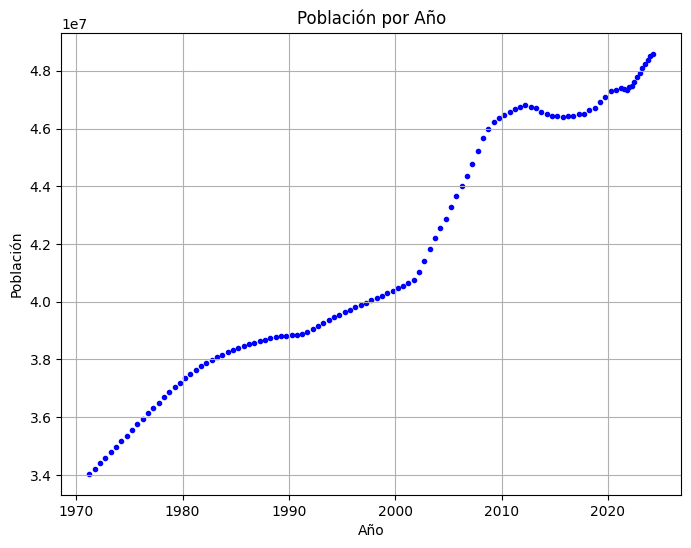

In [99]:
# Visualización de los datos experimentales de manera gráfica
import matplotlib.pyplot as plt # Librería de graficación
import numpy as np # Librería matemática

# Graficación de los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data.index, data['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.title('Población por Año')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

Con el fin de poder simplificar un poco los resultados obtenidos, y teniendo en cuenta los orígenes de nuestros datos, resulta conveniente realizar una pequeña modificación en estos, modificación que posteriormente será reversada para ver los resultados obtenidos. En este caso, vemos algo conveniente realizar una especie de traslación de nuestros datos o de nuestro sistema coordenado, con el fin de usar la convención de que el inicio de la toma de los datos se realizó en $1971$. Así pues, este será nuestro tiempo inicial ($t=0$). A continuación se realiza la traslación descrita y visualizamos nuevamente los datos en una gráfica.

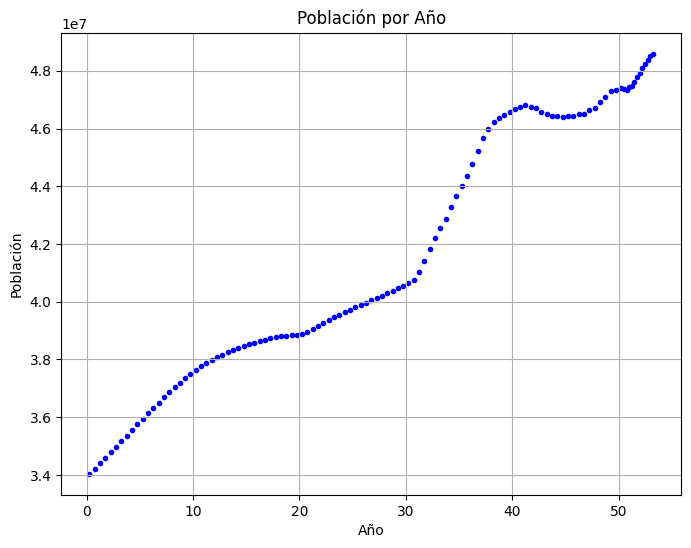

,POBLACIÓN
TIEMPO,
53.25,48592909
53.00,48507039
52.75,48373336
52.50,48233001
52.25,48085361


In [100]:
# Traslación del origen coordenado

# Crear una copia de los datos
data_traslacion = data.copy()

# Trasladar el tiempo para que el tiempo inicial sea el año 1971
data_traslacion.index = data_traslacion.index - 1971

# Graficación de los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.title('Población por Año')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

# Impresión de la muestra de los datos
data_traslacion.head()

Adicionalmente, y como un análisis algo paralelo y que a mi pensamiento, nos podría colaborar con la corroboración de los resultados ante una presunta duda de la cantidad de los datos usados, vamos a hacer uso de un desarrollo paralelo, en el cual tomaremos el 10% aproximadamente de los datos, es decir, alrededor de 12 datos, para realizar el mismo ajuste de función exponencial para ver qué resultados obtenemos y verificar si los resultados de la optimización dependen mucho o no de la cantidad de datos experimentales ingresados (a pesar de que apriori, entre más datos mejor). Así pues, procedemos a tomar la muestra de datos mencionada

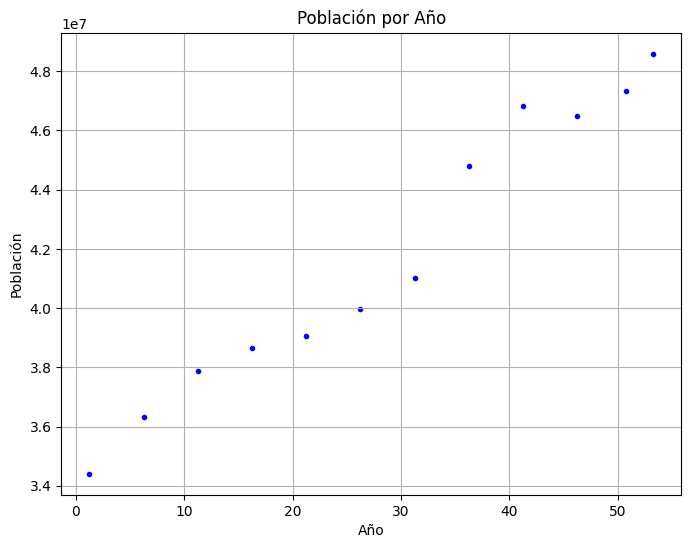

,POBLACIÓN
TIEMPO,
53.25,48592909
50.75,47346836
46.25,46497393
41.25,46818216
36.25,44784659
31.25,41035271
26.25,39971329
21.25,39051336
16.25,38638052


In [101]:
# Selección de los datos
data_alter = data_traslacion.iloc[[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]]

# Graficación de los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_alter.index, data_alter['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.title('Población por Año')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

# Impresión de los datos seleccionados
data_alter

### 2. Implementación de los métodos
Como primer paso, se procederá a definir la función objetivo a minimizar, la cual corresponde a la suma de los errores cuadráticos entre los datos experimentales y el modelo exponencial.
Posteriormente a esto, se realizará la implementación de los dos métodos pedidos, el método de región de confianza (con la orientación del método Dogleg para la solución del subproblema teórico) y el método de Gauss-Newton para encontrar los valores de los parámetros $C_0$ y $k$ que mejor se ajusten a los datos experimentales.

#### Función Objetivo

In [102]:
def objective_function(params, t, c):
    """
    Función objetivo a minimizar
    :param params: Parámetros a optimizar
    :param t: Tiempo
    :param c: Población
    :return: Error cuadrático
    """
    c0, k = params
    return np.sum((c - c0 * np.exp(k * t)) ** 2) / 2

#### Método de Región de Confianza

In [103]:
from autograd import grad, hessian
import autograd.numpy as np

# Definición de la función m_k
def m_k(funcion_objetivo, params, t, c, p):
    """
    Función m_k; función cuadrática de modelo en cada iteración
    :param funcion_objetivo: Función objetivo a minimizar 
    :param params: Parámetros a optimizar
    :param t: Tiempo
    :param c: Población
    :param p: Dirección de búsqueda
    :return: Valor de la función m_k
    """
    
    return funcion_objetivo(params, t, c) + grad(funcion_objetivo)(params, t, c).dot(p) + 0.5 * p.dot((hessian(funcion_objetivo)(params, t, c) @ p))


# Implementación del algoritmo de búsqueda de dirección usando el método de Dogleg (subproblema generado en el método de región de confianza)
def algoritmo_dogleg(grad_f, hess_f, r_k):
    """
    Función que implementa el método de Dogleg para la solución del subproblema generado en el método de región de confianza
    :param grad_f: Gradiente de la función objetivo
    :param hess_f: Hessiano de la función objetivo
    :param r_k: Radio de confianza
    :return: Dirección de búsqueda
    """
    
    p_u = - (grad_f.dot(grad_f) / (grad_f.dot(hess_f * grad_f))) * grad_f
    p_n = - np.linalg.inv(hess_f) @ grad_f
    
    if np.linalg.norm(p_n) <= r_k:
        return p_n
    
    if np.linalg.norm(p_u) >= r_k:
        return - r_k * p_u / np.linalg.norm(p_u)
    else:
        # Resolver la ecuación cuadrática a(τ − 1)2 + b(τ − 1) + c = 0
        a = p_n.dot(p_n) - 2 * p_n.dot(p_u) + p_u.dot(p_u)
        b = 2 * p_n.dot(p_u) - 2 * p_u.dot(p_u)
        c = p_u.dot(p_u) - r_k**2
        tau = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
        tau = tau + 1
        return p_u + tau * (p_n - p_u)
    

# Implementación del algoritmo del método de región de confianza
def region_confianza(funcion_objetivo, initial_params, t, c, delta = 0.1, eta = 0.1, max_iter = 1000, tol = 1e-6):
    """
    Método de región de confianza
    :param funcion_objetivo: Función objetivo a minimizar
    :param initial_params: Parámetros iniciales
    :param t: Tiempo
    :param c: Población
    :param delta: Delta inicial entre 0 y 1
    :param eta: Eta inicial entre 0 y 0.25
    :param max_iter: Número máximo de iteraciones
    :param tol: Tolerancia
    :return: Parámetros óptimos
    """
    params = initial_params
    radius = 0.1
    iteration = 0
    while funcion_objetivo(params, t, c) > tol and iteration < max_iter:
        
        # Calculamos el gradiente y la matriz Hessiana
        grad_f = grad(funcion_objetivo)(params, t, c)
        hess_f = hessian(funcion_objetivo)(params, t, c)
        
        # Obtener la dirección de descenso p_k
        p_k = algoritmo_dogleg(grad_f, hess_f, radius)

        # Evaluar rho_k
        rho_k = (funcion_objetivo(params, t, c) - funcion_objetivo((params + p_k), t, c)) / (m_k(funcion_objetivo, params, t, c, np.array([0,0])) - m_k(funcion_objetivo, params, t, c, p_k))
        
        # Actualizar el radio de confianza
        if rho_k < 0.25:
            radius = np.linalg.norm(p_k) / 4
        else:
            if rho_k > 0.75 and np.linalg.norm(p_k) == radius:
                radius = min(2 * radius, delta)
        
        # Actualizar los parámetros
        if rho_k > eta:
            params += p_k
            
        iteration += 1
        
    return params

#### Método de Gauss-Newton

Para el desarrollo del método de Gauss-Newton, haremos uso de algunos algoritmos previamente desarrollados en la Tarea 1 de la materia, los cuales corresponden a la búsqueda del tamaño de paso de una manera en la que se cumplan las condiciones de Armijo y de Wolfe. A continuación, se traen a colación dichos algoritmos ya desarrollados.

In [104]:
# Condición de Armijo
def condicion_armijo(f, x, t, c, p, alpha, c1):
    """
    Condición de Armijo
    :param f: Función objetivo
    :param x: Punto actual
    :param t: Tiempo
    :param c: Población
    :param p: Dirección de búsqueda
    :param alpha: Tamaño de paso
    :param c1: Parámetro de la condición de Armijo
    :return: Booleano
    """
    return f(x + alpha * p, t, c) <= f(x, t, c) + c1 * alpha * grad(f)(x, t, c).dot(p)


# Condición de Wolfe
def condicion_wolfe(f, x, t, c, p, alpha, c2):
    """
    Condición de Wolfe
    :param f: Función objetivo
    :param x: Punto actual
    :param t: Tiempo
    :param c: Población
    :param p: Dirección de búsqueda
    :param alpha: Tamaño de paso
    :param c2: Parámetro de la condición de Wolfe
    :return: Booleano
    """
    return grad(f)(x + alpha * p, t, c).dot(p) >= c2 * grad(f)(x, t, c).dot(p)


# Algoritmo de búsqueda de paso
def busqueda_paso(f, x, t, c, p, alpha, c1, c2, rho):
    """
    Algoritmo de búsqueda de paso
    :param f: Función objetivo
    :param x: Punto actual
    :param t: Tiempo
    :param c: Población
    :param p: Dirección de búsqueda
    :param alpha: Tamaño de paso
    :param c1: Parámetro de la condición de Armijo
    :param c2: Parámetro de la condición de Wolfe
    :param rho: Factor de reducción del tamaño de paso
    :return: Tamaño de paso
    """
    # Verificamos que los valores de los parámetros sean válidos
    if c1 <= 0 or c1 >= 1:
        print('El valor de c1 no es válido')
        return
    if c2 <= c1 or c2 >= 1:
        print('El valor de c2 no es válido')
        return
    if rho <= 0 or rho >= 1:
        print('El valor de rho no es válido')
        return
    # Buscamos el tamaño de paso
    while not (condicion_wolfe(f, x, t, c, p, alpha, c2) and condicion_armijo(f, x, t, c, p, alpha, c1)):
        alpha = rho * alpha
    return alpha


from autograd import jacobian


# Método de Gauss-Newton
def gauss_newton(funcion_objetivo, x0, t, c, tol=1e-6, max_iter=100):
    """
    Método de Gauss-Newton
    :param funcion_objetivo: Función objetivo a minimizar
    :param x0: Punto inicial
    :param t: Tiempo
    :param c: Población
    :param tol: Tolerancia
    :param max_iter: Número máximo de iteraciones
    :return: Parámetros óptimos
    """
    x = x0
    iteration = 0

    # Definimos la función r_k
    def r_k(x, t, c):
        return (c - x[0] * np.exp(x[1] * t))**2

    while funcion_objetivo(x, t, c) > tol and iteration < max_iter:
        # Calcular el Jacobiano
        jac_f = jacobian(r_k)(x, t, c)
        
        t1 = np.linalg.inv(np.dot(jac_f.T, jac_f))
        t2 = np.dot(t1, jac_f.T)
        t3 = np.dot(t2, r_k(x, t, c))
        p = t3
        
        # Buscar el tamaño de paso
        alpha = 1
        c1 = 1e-4
        c2 = 0.9
        rho = 0.5
        alpha = busqueda_paso(funcion_objetivo, x, t, c, p, alpha, c1, c2, rho)

        # Actualizar x
        x -= alpha * p

        iteration += 1

    return x

### 3. Resolución del Problema

A continuación se procede entonces a resolver el problema mencionado al inicio del informe, un problema de ajuste de parámetros a los datos experimentales usando los métodos de región de confianza y de Gauss-Newton implementados anteriormente. Básicamente implementaremos los algoritmos con nuestra función y nuestros datos para en un paso posterior realizar un análisis de los resultados obtenidos. Como parte adicional, en esta sección haremos una pequeña comparación de los resultados obtenidos por nuestros métodos con los métodos ya previamente desarrollados por la librería Scipy, esto con el fin de estar seguros de que nuestra implementación es la correcta.

Para lograr nuestro objetivo de resolver el problema, tomaremos como aproximación inicial un arreglo de dos elementos, donde el primero de ellos corresponde a la población inicial de nuestros datos experimentales (se espera que el modelo siga este valor como población inicial) y el segundo corresponde a la tasa de crecimiento, cuyo valor fue tomado a partir de la relación que existe en los datos experimentales y la relación esperada entre estos, usando el significado conceptual de tasa de crecimiento y los significados prácticos del modelo.

#### Solución para todo el Conjunto de Datos

In [105]:
# Definición de los datos experimentales
t = data_traslacion.index.values
c = data_traslacion['POBLACIÓN'].values

# Conversión de los datos a tipo float para operar más cómodamente
t = t.astype(float)
c = np.array(c, dtype=float)

# Defino los valores iniciales de c0 y k descritos anteriormente
k_inicial = np.log(c[0] / c[-1]) / (t[0] - t[-1])
x0 = np.array([c[-1], k_inicial])
print(x0)

[3.40406420e+07 6.71551795e-03]


##### - Solución con el Método de Región de Confianza

In [106]:
# Solución del problema usando el método de región de confianza
params_rc = region_confianza(objective_function, x0, t, c)

# Desempaqueto los resultados obtenidos
c0_optimo_rc, k_optimo_rc = params_rc

# Muestro los resultados
print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', c0_optimo_rc)
print('Tasa de crecimiento estimada (k):', k_optimo_rc)

print("\n")


# Solución con el método de optimización de Scipy
from scipy.optimize import minimize

params_rc_sc = minimize(objective_function, x0, (t, c), method="dogleg", jac=jacobian(objective_function), hess=hessian(objective_function))

# Desempaqueto los resultados obtenidos
c0_optimo_rc_sc, k_optimo_rc_sc = params_rc_sc.x

# Muestro los resultados
print("Parámetros encontrados por Scipy:")
print("Población inicial estimada (C0):", c0_optimo_rc_sc)
print("Tasa de crecimiento estimada (k):", k_optimo_rc_sc)

Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 34040541.99999851
Tasa de crecimiento estimada (k): 0.006715443353231313

Parámetros encontrados por Scipy:
Población inicial estimada (C0): 34431564.999998495
Tasa de crecimiento estimada (k): 0.006581596718761363


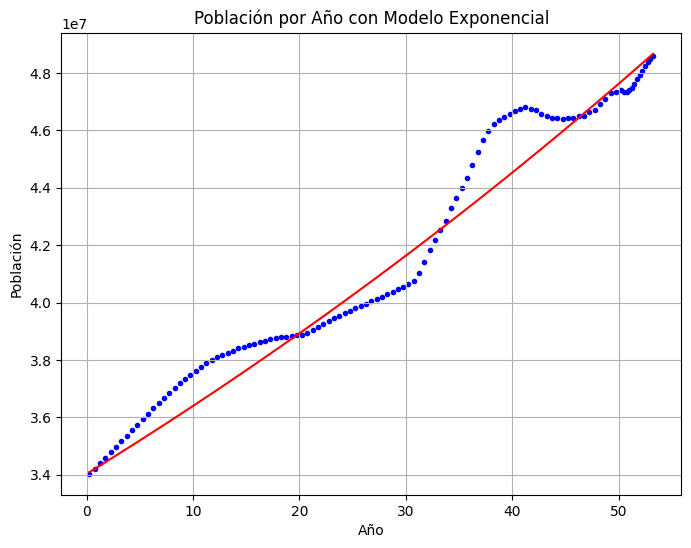

In [107]:
# Impresión de los resultados obtenidos por el método de región de confianza
# Graficación de los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_traslacion.index, c0_optimo_rc * np.exp(k_optimo_rc * t), color='red') # Modelo exponencial resultante
plt.title('Población por Año con Modelo Exponencial')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

##### - Solución con el método de Gauss-Newton

In [108]:
# Solución del problema usando el método de Gauss-Newton
params_gn = gauss_newton(objective_function, x0, t, c)

# Desempaqueto los resultados obtenidos
c0_optimo_gn, k_optimo_gn = params_gn

# Muestro los resultados
print('Parámetros encontrados por Gauss-Newton:')
print('Población inicial estimada (C0):', c0_optimo_gn)
print('Tasa de crecimiento estimada (k):', k_optimo_gn)

print("\n")


# Solución con el método de optimización de Scipy
from scipy.optimize import minimize

params_gn_sc = minimize(objective_function, x0, (t, c), method="trust-ncg", jac=jacobian(objective_function), hess=hessian(objective_function))

# Desempaqueto los resultados obtenidos
c0_optimo_gn_sc, k_optimo_gn_sc = params_gn_sc.x

# Muestro los resultados
print("Parámetros encontrados por Scipy:")
print("Población inicial estimada (C0):", c0_optimo_gn_sc)
print("Tasa de crecimiento estimada (k):", k_optimo_gn_sc)

Parámetros encontrados por Gauss-Newton:
Población inicial estimada (C0): 34040541.99999851
Tasa de crecimiento estimada (k): 0.006715443353231313

Parámetros encontrados por Scipy:
Población inicial estimada (C0): 34230564.99999851
Tasa de crecimiento estimada (k): 0.0067303636938931075


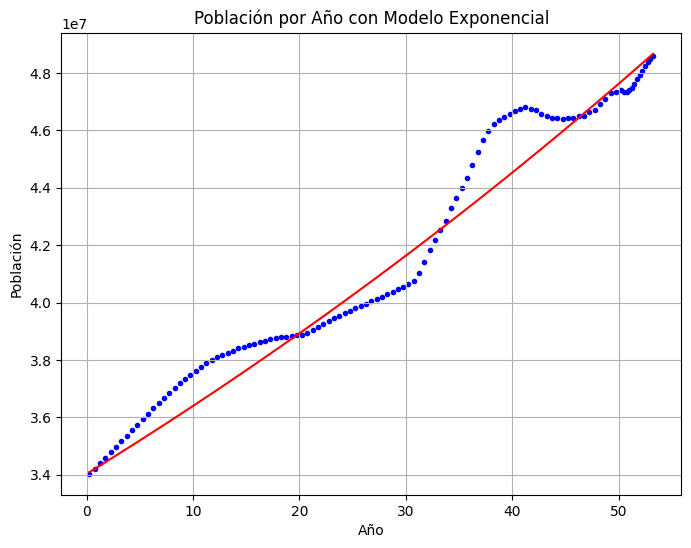

In [109]:
# Impresión de los resultados obtenidos por el método de Gauss-Newton
# Graficación de los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_traslacion.index, c0_optimo_gn * np.exp(k_optimo_gn * t), color='red') # Modelo exponencial resultante
plt.title('Población por Año con Modelo Exponencial')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

#### Solución para el Conjunto Parcial de Datos

In [110]:
# Definición de los datos experimentales
t = data_alter.index.values
c = data_alter['POBLACIÓN'].values

# Conversión de los datos a tipo float para operar más cómodamente
t = t.astype(float)
c = np.array(c, dtype=float)

# Defino los valores iniciales de c0 y k descritos anteriormente
k_inicial = np.log(c[0] / c[-1]) / (t[0] - t[-1])
x0 = np.array([c[-1], k_inicial])
print(x0)

[3.44083380e+07 6.63805185e-03]


##### - Solución con el Método de Región de Confianza

In [111]:
# Solución del problema usando el método de región de confianza
params_rc_alter = region_confianza(objective_function, x0, t, c)

# Desempaqueto los resultados obtenidos
c0_optimo_rc_alter, k_optimo_rc_alter = params_rc_alter

# Muestro los resultados
print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', c0_optimo_rc_alter)
print('Tasa de crecimiento estimada (k):', k_optimo_rc_alter)

print("\n")


# Solución con el método de optimización de Scipy
from scipy.optimize import minimize

params_rc_sc_alter = minimize(objective_function, x0, (t, c), method="dogleg", jac=jacobian(objective_function), hess=hessian(objective_function))

# Desempaqueto los resultados obtenidos
c0_optimo_rc_sc_alter, k_optimo_rc_sc_alter = params_rc_sc_alter.x

# Muestro los resultados
print("Parámetros encontrados por Scipy:")
print("Población inicial estimada (C0):", c0_optimo_rc_sc_alter)
print("Tasa de crecimiento estimada (k):", k_optimo_rc_sc_alter)

Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 34408438.00000149
Tasa de crecimiento estimada (k): 0.0066381234685072635

Parámetros encontrados por Scipy:
Población inicial estimada (C0): 34543036.90447431
Tasa de crecimiento estimada (k): 0.006475905573186967


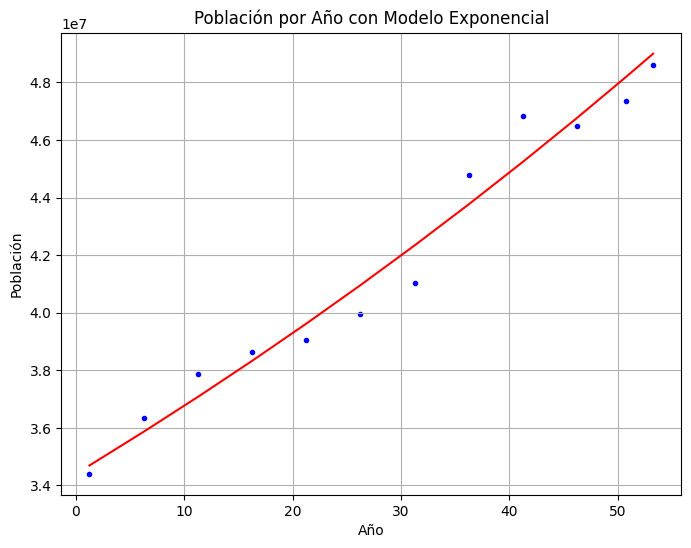

In [112]:
# Impresión de los resultados obtenidos por el método de región de confianza
# Graficación de los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_alter.index, data_alter['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_alter.index, c0_optimo_rc_alter * np.exp(k_optimo_rc_alter * t), color='red') # Modelo exponencial resultante
plt.title('Población por Año con Modelo Exponencial')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

##### - Solución con el Método de Gauss-Newton

In [113]:
# Solución del problema usando el método de Gauss-Newton
params_gn_alter = gauss_newton(objective_function, x0, t, c)

# Desempaqueto los resultados obtenidos
c0_optimo_gn_alter, k_optimo_gn_alter = params_gn_alter

# Muestro los resultados
print('Parámetros encontrados por Gauss-Newton:')
print('Población inicial estimada (C0):', c0_optimo_gn_alter)
print('Tasa de crecimiento estimada (k):', k_optimo_gn_alter)

print("\n")


# Solución con el método de optimización de Scipy
from scipy.optimize import minimize

params_gn_sc_alter = minimize(objective_function, x0, (t, c), method="trust-ncg", jac=jacobian(objective_function), hess=hessian(objective_function))

# Desempaqueto los resultados obtenidos
c0_optimo_gn_sc_alter, k_optimo_gn_sc_alter = params_gn_sc_alter.x

# Muestro los resultados
print("Parámetros encontrados por Scipy:")
print("Población inicial estimada (C0):", c0_optimo_gn_sc_alter)
print("Tasa de crecimiento estimada (k):", k_optimo_gn_sc_alter)

Parámetros encontrados por Gauss-Newton:
Población inicial estimada (C0): 34214166.999582924
Tasa de crecimiento estimada (k): 0.006862501665785863

Parámetros encontrados por Scipy:
Población inicial estimada (C0): 34404189.999582924
Tasa de crecimiento estimada (k): 0.006575282473097229


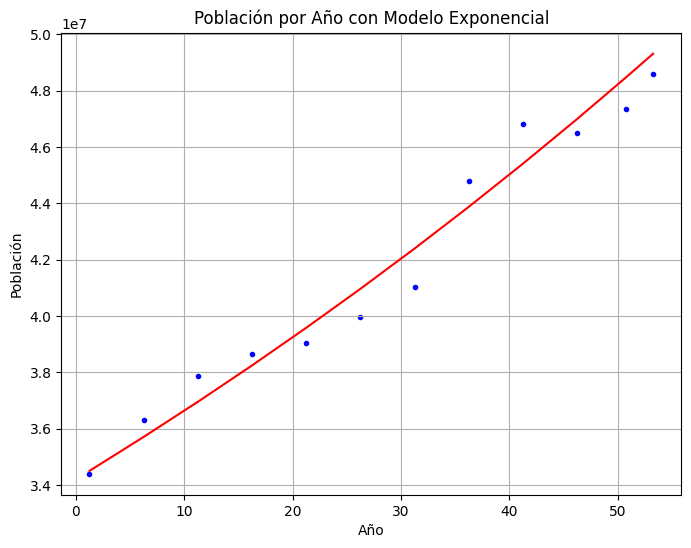

In [114]:
# Impresión de los resultados obtenidos por el método de Gauss-Newton
# Graficación de los datos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_alter.index, data_alter['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_alter.index, c0_optimo_gn_alter * np.exp(k_optimo_gn_alter * t), color='red') # Modelo exponencial resultante
plt.title('Población por Año con Modelo Exponencial')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

Como pudimos evidenciar, y como análisis algo adelantado, los resultados obtenidos por los métodos manualmente implementados y por los métodos que nos ofrece la librería Scipy son bastante similares, pues los valores en los que difieren son minúsculos y se remontan a decimales demasiado pequeños y poco representativos para el problema y el punto inicial de población, a pesar de que varía un poco más fuertemente, en estos valores tan grandes no tiene mucho impacto y estos errores pueden haber sido ocasionados por redondeos, evaluaciones, cantidad de iteraciones y demás aspectos que intervengan en el desarrollo de la optimización, por lo que esto, en general, nos sugiere que los métodos implementados son correctos y podemos proceder a realizar un análisis un poco más detallado de estos resultados. Adicionalmente, a simple vista se ve una curva exponencial bastante centrada y bien ajustada.

### 4. Discusión de los Resultados Obtenidos

En este apartado, procederemos a comparar los resultados obtenidos por el método de región de confianza y el método de Gauss-Newton. Para esto, se compararán los valores de $C_0$ y $k$ obtenidos por ambos métodos y se realizará una comparación de manera gráfica entre los resultados de los modelos, en busca de diferencias entre estos.

Además de esto, se realizarán ciertas anotaciones con respecto al tiempo de ejecución de los métodos, para ver su efectividad. Finalmente, haremos un breve análisis de los resultados aplicados a nuestro problema experimental, comentando algunos retos que se tuvieron y algunas interpretaciones de los resultados obtenidos.

Primero, recordemos un poco cuáles fueron los resultados obtenidos por los métodos de región de confianza y Gauss-Newton que fueron aplicados en el proceso anterior.

In [115]:
# Para la totalidad de los datos
print('PARÁMETROS ENCONTRADOS USANDO LA TOTALIDAD DE LOS DATOS')

print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', c0_optimo_rc)
print('Tasa de crecimiento estimada (k):', k_optimo_rc)

print('')

print('Parámetros encontrados por Gauss-Newton:')
print('Población inicial estimada (C0):', c0_optimo_gn)
print('Tasa de crecimiento estimada (k):', k_optimo_gn)

print('\n')

# Para los datos parciales
print('PARÁMETROS ENCONTRADOS USANDO DATOS PARCIALES')

print('Parámetros encontrados por región de confianza:')
print('Población inicial estimada (C0):', c0_optimo_rc_alter)
print('Tasa de crecimiento estimada (k):', k_optimo_rc_alter)

print('')

print('Parámetros encontrados por Gauss-Newton:')
print('Población inicial estimada (C0):', c0_optimo_gn_alter)
print('Tasa de crecimiento estimada (k):', k_optimo_gn_alter)

PARÁMETROS ENCONTRADOS USANDO LA TOTALIDAD DE LOS DATOS
Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 34040541.99999851
Tasa de crecimiento estimada (k): 0.006715443353231313

Parámetros encontrados por Gauss-Newton:
Población inicial estimada (C0): 34040541.99999851
Tasa de crecimiento estimada (k): 0.006715443353231313


PARÁMETROS ENCONTRADOS USANDO DATOS PARCIALES
Parámetros encontrados por región de confianza:
Población inicial estimada (C0): 34408438.00000149
Tasa de crecimiento estimada (k): 0.0066381234685072635

Parámetros encontrados por Gauss-Newton:
Población inicial estimada (C0): 34214166.999582924
Tasa de crecimiento estimada (k): 0.006862501665785863


En una comparación cuantitativa, tenemos dos caras de la moneda y es que, cuando estamos trabajando con la totalidad de los datos, los resultados de ambos métodos son bastante parecidos y a primera vista pareciesen ser idénticos, esto nos podría sugerir un gran parecido entre los métodos y sus resultados, cuando se parte desde el mismo punto. Empero, cuando se hace el procedimiento usando los datos parciales se obtienen ciertas diferencias en lo que respecta a la población inicial estimada, aunque en la tasa de crecimiento sean decimales los que difieran. Así pues, se puede notar como las diferencias de los parámetros encontrados por estos métodos no difieren en gran medida y en cuanto a números se habla, pueden llegar a ser útiles variar entre uno y otro para poder hacer uso de ellos en las distintas situaciones cotidianas. Ahora, realicemos una comparación gráfica de los resultados obtenidos por ambos métodos.

##### - Graficaciones de los resultados con la totalidad de los datos

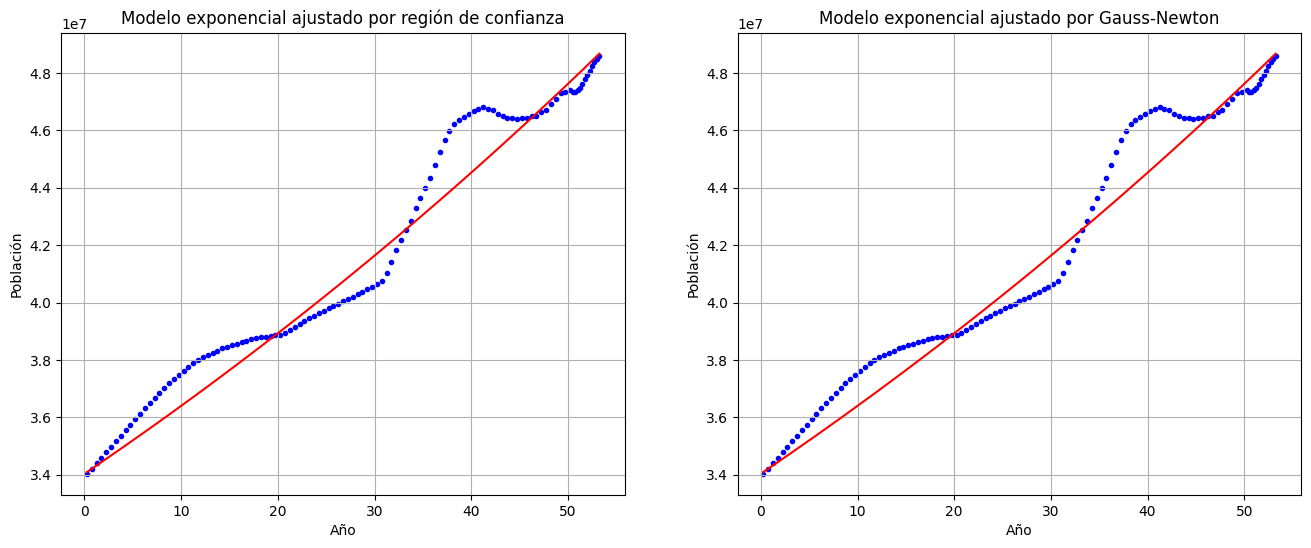

In [116]:
# Visualización de la función obtenida según el método de región de confianza y Gauss-Newton en una figura que tiene al lado izquierdo la función obtenida por región de confianza y al lado derecho la función obtenida por Gauss-Newton

# Definición de los datos experimentales
t = data_traslacion.index.values
c = data_traslacion['POBLACIÓN'].values

# Conversión de los datos a tipo float para operar más cómodamente
t = t.astype(float)
c = np.array(c, dtype=float)

plt.figure(figsize=(16, 6))  # Definir el tamaño de la figura

# Gráfico de la función obtenida por región de confianza
plt.subplot(1, 2, 1)  # Subgráfico 1
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_traslacion.index, c0_optimo_rc * np.exp(k_optimo_rc * t), color='red') # Modelo exponencial resultante
plt.title('Modelo exponencial ajustado por región de confianza')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico

# Gráfico de la función obtenida por Gauss-Newton
plt.subplot(1, 2, 2)  # Subgráfico 2
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_traslacion.index, c0_optimo_gn * np.exp(k_optimo_gn * t), color='red') # Modelo exponencial resultante
plt.title('Modelo exponencial ajustado por Gauss-Newton')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico

plt.show()  # Mostrar el gráfico

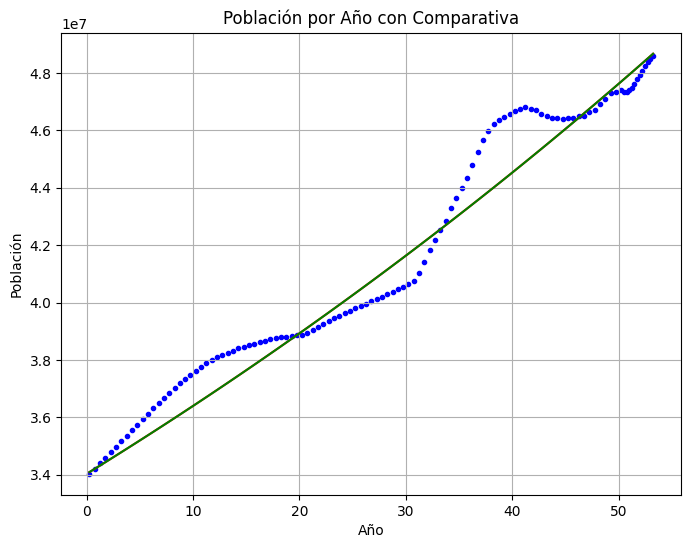

In [117]:
# Graficación de los datos juntos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_traslacion.index, c0_optimo_rc * np.exp(k_optimo_rc * t), color='red') # Modelo exponencial resultante
plt.plot(data_traslacion.index, c0_optimo_gn * np.exp(k_optimo_gn * t), color='green') # Modelo exponencial resultante
plt.title('Población por Año con Comparativa')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

##### - Graficaciones de los resultados con los datos parciales

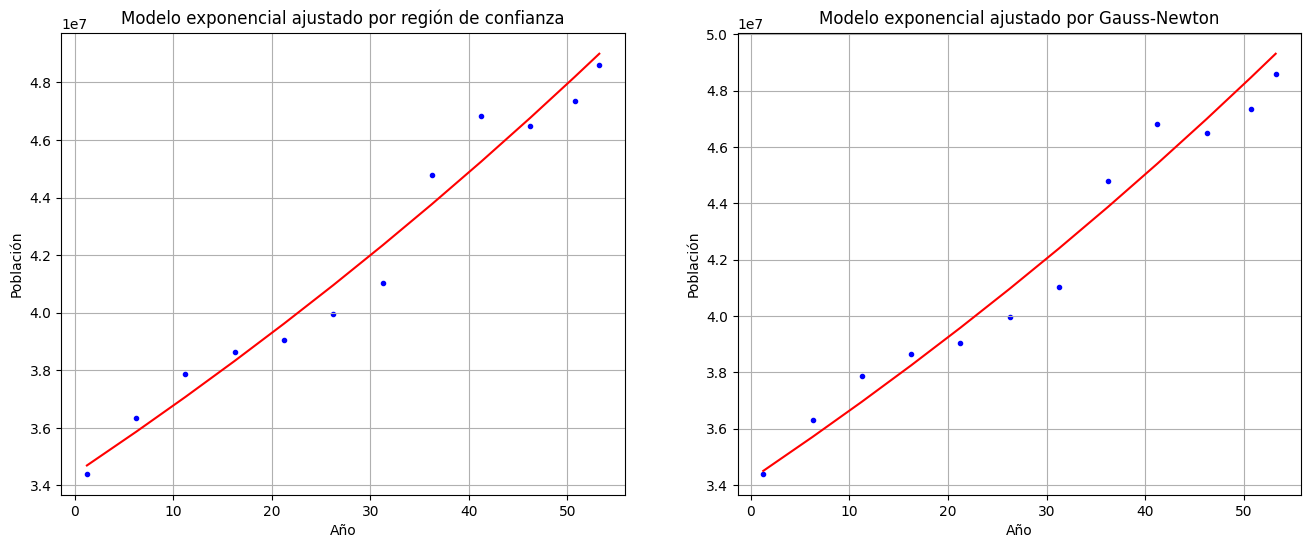

In [118]:
# Visualización de la función obtenida según el método de región de confianza y Gauss-Newton en una figura que tiene al lado izquierdo la función obtenida por región de confianza y al lado derecho la función obtenida por Gauss-Newton

# Definición de los datos experimentales
t = data_alter.index.values
c = data_alter['POBLACIÓN'].values

# Conversión de los datos a tipo float para operar más cómodamente
t = t.astype(float)
c = np.array(c, dtype=float)

plt.figure(figsize=(16, 6))  # Definir el tamaño de la figura

# Gráfico de la función obtenida por región de confianza
plt.subplot(1, 2, 1)  # Subgráfico 1
plt.scatter(data_alter.index, data_alter['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_alter.index, c0_optimo_rc_alter * np.exp(k_optimo_rc_alter * t), color='red') # Modelo exponencial resultante
plt.title('Modelo exponencial ajustado por región de confianza')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico

# Gráfico de la función obtenida por Gauss-Newton
plt.subplot(1, 2, 2)  # Subgráfico 2
plt.scatter(data_alter.index, data_alter['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_alter.index, c0_optimo_gn_alter * np.exp(k_optimo_gn_alter * t), color='red') # Modelo exponencial resultante
plt.title('Modelo exponencial ajustado por Gauss-Newton')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico

plt.show()  # Mostrar el gráfico

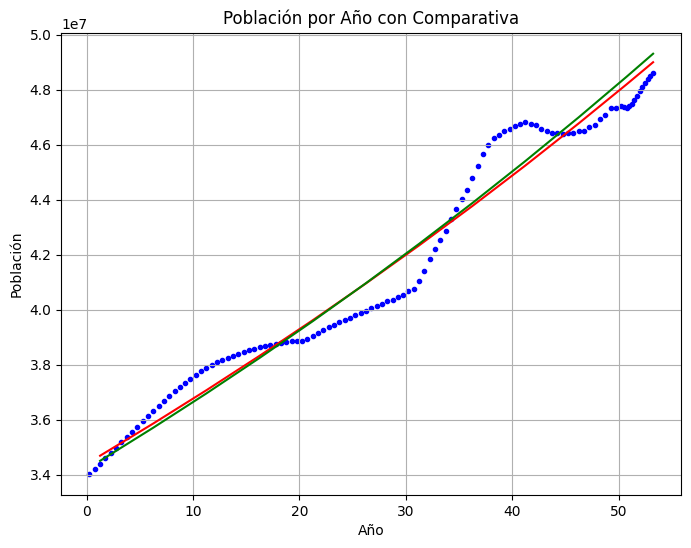

In [119]:
# Graficación de los datos juntos
plt.figure(figsize=(8, 6))  # Definir el tamaño de la figura
plt.scatter(data_traslacion.index, data_traslacion['POBLACIÓN'], color='blue', marker='.')  # Colocación de los datos como puntos
plt.plot(data_alter.index, c0_optimo_rc_alter * np.exp(k_optimo_rc_alter * t), color='red') # Modelo exponencial resultante
plt.plot(data_alter.index, c0_optimo_gn_alter * np.exp(k_optimo_gn_alter * t), color='green') # Modelo exponencial resultante
plt.title('Población por Año con Comparativa')  # Título del gráfico
plt.xlabel('Año')  # Etiqueta del eje x
plt.ylabel('Población')  # Etiqueta del eje y
plt.grid(True)  # Mostrar una cuadrícula en el gráfico
plt.show()  # Mostrar el gráfico

Como pudimos evidenciar en nuestros resultados cuantitativos, en los resultados vistos gráficamente se percibe algo totalmente similar y es que, cuando usamos la totalidad de los datos vemos como los dos modelos exponenciales se superponen y resultan ser iguales. Sin embargo, cuando reducimos la muestra notamos algo bastante interesante y es que, al hacer la comparativa entre los modelos resultantes, vemos como difieren un poco en su punto inicial y en su pendiente, diferencias que son muy pequeñas y que se puede decir que se compensan, pues si inicias más abajo resultas tener una pendiente un poco más positiva que compensa y de manera análoga con el otro caso, esto puede ser ocasionado básicamente porque estamos "pagando" las diferencias de la función al inicio o al final de la aproximación, lo cual resulta ser bastante interesante porque se puede relacionar (en una suposición) con la manera en la que nos aproximamos al resultado.

Finalmente, antes de unas conclusiones finales del trabajo, procederemos a realizar una comparación entre los tiempos de ejecución de los métodos, parte fundamental cuando queremos escalar los datos y los algoritmos.

In [120]:
import time

# Para la totalidad de los datos

# Método de región de confianza
start_time = time.time()
aux_rc = region_confianza(objective_function, x0, t, c)
end_time = time.time()
tiempo_rc = end_time - start_time

# Método de Gauss-Newton
start_time = time.time()
aux_gn = gauss_newton(objective_function, x0, t, c)
end_time = time.time()
tiempo_gn = end_time - start_time

print('Tiempos para la totalidad de los datos')
print('Tiempo de ejecución del método de región de confianza:', tiempo_rc)
print('Tiempo de ejecución del método de Gauss-Newton:', tiempo_gn)

print('')

# Para los datos parciales

# Método de región de confianza
start_time = time.time()
aux_rc_alter = region_confianza(objective_function, x0, t, c)
end_time = time.time()
tiempo_rc_alter = end_time - start_time

# Método de Gauss-Newton
start_time = time.time()
aux_gn_alter = gauss_newton(objective_function, x0, t, c)
end_time = time.time()
tiempo_gn_alter = end_time - start_time

print('Tiempos para los datos parciales')
print('Tiempo de ejecución del método de región de confianza:', tiempo_rc_alter)
print('Tiempo de ejecución del método de Gauss-Newton:', tiempo_gn_alter)

Tiempos para la totalidad de los datos
Tiempo de ejecución del método de región de confianza: 7.681354284286499
Tiempo de ejecución del método de Gauss-Newton: 5.669420480728149
Tiempos para los datos parciales
Tiempo de ejecución del método de región de confianza: 5.4830100536346436
Tiempo de ejecución del método de Gauss-Newton: 5.682802677154541


Finalmente, haciendo algunos análisis de la duración aproximada del desarrollo del proceso de optimización realizado por cada algoritmo, sucede algo muy peculiar y es que, al parecer, sin importar mucho la cantidad de los datos experimentales que se tienen, en principio, la duración de los algoritmos es bastante estable. Además de esto, resulta que, aunque es por muy poco, en uno de los casos el método de región de confianza fue más lento y en el otro el de Gauss-Newton fue más lento, lo cual es bastante extraño. A pesar de que, en las numerosas pruebas que se realizaron, el método de región de confianza pareció ser siempre un poco más eficiente, este tipo de funciones deja claro que si hay una diferencia, es muy poca y ambos resultan ser bastante eficientes. Cabe destacar de igual manera que, estos tiempos varían según el punto inicial que se tome y la cantidad máxima de iteraciones que se configuran en el algoritmo. En resumen, ambos métodos son bastante efectivos en lo que es tiempo de ejecución cuando se trate de resolver este tipo de problemas.

Finalmente, y en lo que respecta un poco más al análisis del problema como tal, se puede ver que a simple vista no tendríamos la intención de ajustar un modelo exponencial, pues es que los datos experimentales sugieren poca relación y una gran variación de impulsos en lo que es la población. Sin embargo, cuando se ejecutan los algoritmos y se plasma el modelo parece ser que si se sigue cierta tendencia al modelo, siendo un poco más clara cuando se filtran ciertos datos y se trabaja con una muestra más pequeña de estos. En un análisis más general, podríamos decir que estas latencias que se ven en los datos experimentales pueden haber sido ocasionadas por problemas sociales, tasas de defunción y de natalidad, que se salen un poco del estudio en cuestión, pero que un modelo exponencial de crecimiento poblacional nos hará darnos una idea de como podría ser el crecimiento de cierta población, sin necesidad de buscar la exactitud.

En conclusión, en la realización de estos métodos se pudo evidenciar que ambos llegan a una solución bastante buena del problema de mínimos cuadrados en un proceso que es bastante rápido, en donde ya veremos si es cuestión del usuario o del optimizador analizar los problemas que se poseen y buscar cuál es más adaptable a las condiciones y a la complejidad de los mismos. Ahora bien, estos métodos pueden llegar a diferir un poco en su complejidad en cuanto a programación que se refiere, pues el método de Gauss-Newton parece ser un método mucho más simple, lo que puede ser determinante a la hora de escoger el método a usar. Además de esto, como experiencia del presente trabajo, podemos decir que es bastante importante analizar bien el problema en su teoría, verificar la manera en que se manejan los datos y sobre todo, verificar temas como los puntos iniciales y los parámetros de las funciones, jugar con estos valores puede ser fundamental para hacernos una idea de que es más conveniente para nuestro problema. El manejo, la búsqueda de datos y las dimensiones de las matrices con las cuales se esta trabajando pueden llegar a ser bastante tediosas y pueden llevar a errores muy simples, pero que se escapan fácilmente al ojo humano, y una revisada del problema te puede ayudar a evitar estos problemas y a hacer un mejor manejo de los datos brindados. Finalmente, se puede decir que el trabajo fue bastante interesante y que se logró cumplir con los objetivos planteados en la tarea y pudimos ver como los métodos fueron de ayuda para resolver un problema de la vida cotidiana, como lo es el de ajuste de curas a datos experimentales, en nuestro caso, la población de un país en función del paso del tiempo.